# Imdb

Introduction to `Text analysis` from IMDB reviews for movies. So let's important modules from fastai.

In [1]:
from fastai import *
from fastai.text import *

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

In [2]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

[PosixPath('/home/anass/.fastai/data/imdb_sample/data_save.pkl'),
 PosixPath('/home/anass/.fastai/data/imdb_sample/texts.csv')]

It's just a `csv` file so we could open it with **pandas**

In [3]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


The data contains labels from the *first* column and **Text** in the second. The third column is to determin either the text should be on the **validation** set or not.

In [4]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

Let's create a `dataBunch` from the csv file then

In [6]:
data_lm = TextDataBunch.from_csv(path,'texts.csv')

A text is composed of words, and we can't apply mathematical functions to them directly. 

We first have to convert them to numbers. This is done in two differents steps:
 * tokenization 
 * numericalization.
 
 A TextDataBunch does all of that behind the scenes for you. So let's save the model

In [6]:
data_lm.save()

In [7]:
data_lm.vocab.itos[:10]  # show the list of tokens

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the']

Let's get a look a single data element

In [8]:
data_lm.train_ds[0][0].data[:10]  # it's a list of element each one representing a vocabulary token

array([   2,   19,   42,   15,   43, 1364,   10,   19,   25,  981])

Let's do this with `data block` API

In [9]:
data = (TextList.from_csv(path,'texts.csv',cols='text')
       .split_from_df(col=2)
       .label_from_df(cols=2)
       .databunch())

/home/anass/anaconda3/envs/fastai/lib/python3.7/site-packages/fastai/data_block.py:519: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
True
  if getattr(ds, 'warn', False): warn(ds.warn)


## Language model

For **NLP** Problems, we must creat two models

* **Language model** : with word embedding
* **classifier**: with Rucurrent Neural networks

In [10]:
bs =  48        #batch size

In [11]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/anass/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/anass/.fastai/data/imdb/tmp_clas'),
 PosixPath('/home/anass/.fastai/data/imdb/models'),
 PosixPath('/home/anass/.fastai/data/imdb/data_lm.pkl'),
 PosixPath('/home/anass/.fastai/data/imdb/test'),
 PosixPath('/home/anass/.fastai/data/imdb/unsup'),
 PosixPath('/home/anass/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/anass/.fastai/data/imdb/train'),
 PosixPath('/home/anass/.fastai/data/imdb/README')]

In [12]:
(path/'train').ls()

[PosixPath('/home/anass/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/anass/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/anass/.fastai/data/imdb/train/pos'),
 PosixPath('/home/anass/.fastai/data/imdb/train/neg')]

The data is split by folder with **train**, **test** and unlabelled data

In [13]:
data_lm = (TextList.from_folder(path)
          .filter_by_folder(include=['train','test'])
          .split_by_rand_pct(0.1)
          .label_for_lm()
          .databunch(bs=bs))

In [12]:
#save the model to load quickly next time
#data_lm.save('data_lm.pkl')
data_lm = load_data(path, 'data_lm.pkl', bs = bs)

In [13]:
data_lm.show_batch()

idx,text
0,good looking little movie more akin to the low budget films of its day . xxmaj despite what you may think this film actually has a good script with funny jokes and good songs . xxmaj its an naughty little tale for adults . xxmaj if you 're wondering whether or not my recommendation is a good one or not consider that the film was pretty much only available
1,"head off and start anew . xxmaj strangely enough , she travels with her husband 's mistress , who is forgiveable given that the sleazebag never told her he was married . xxmaj and together , while driving in the pouring rain , they meet a third , very mysterious young man with a suitcase full of secrets . xxmaj while they 're giddy and free and all suspicious"
2,"you absolutely have no idea of what 's happening or why , and this feeling of utter xxunk is unquestionably the film 's main xxunk . xxmaj as a viewer , you crave to help this poor woman understand the things that overcome her , but you simply ca n't . xxmaj alice has a successful career as an interpreter , but her quiet and peaceful life gets brutally"
3,"on , xxmaj bruno calls himself a "" bum "" , accurate enough except for our rooting interest in him , even as he wrecks xxmaj guy 's life with his homicidal meddling . xxmaj it 's the ultimate perverse underdog 's tale . xxmaj there 's a sense of integrity about xxmaj bruno , in his dogged dedication , which commands our respect and which xxmaj hitchcock plays"
4,"( with english subtitles ) . xxmaj the documentary proved extra interesting when it analyzed the often censored "" xxmaj emmanuelle xxmaj in xxmaj america "" . xxmaj here xxmaj d'amato xxunk the faked "" snuff "" scenes in detail and recalls some funny stories . xxmaj in fact , good ol' xxmaj joe is very warm and funny throughout , always wearing a smile and smoking a cigarette"


Let's create a langage `model_learner` practically, this is a class to perform `Reccurent Neural network` to learn the best represenation of the text.

In [14]:
learn =  language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [15]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


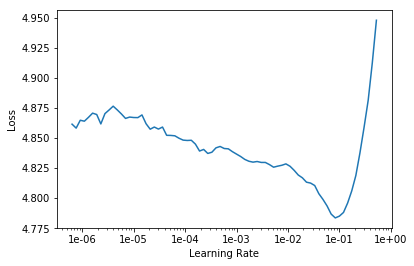

In [17]:
learn.recorder.plot(skip_end=15)

In [18]:
learn.fit_one_cycle(1,1e-2, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.176400,4.028815,0.293845,19:34


In [19]:
learn.save('fit_head')

In [20]:
learn.load('fit_head')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (45000 items)
x: LMTextList
xxbos xxmaj adult version of the classic xxmaj lewis xxmaj carroll tale is much better than you might expect . xxmaj here xxmaj alice is a virginal librarian who falls down the rabbit hole and learns to love sex and her own self image . xxmaj made at the time when adult films were creative endeavors with plots instead of just a series of sex scenes , this is a good looking little movie more akin to the low budget films of its day . xxmaj despite what you may think this film actually has a good script with funny jokes and good songs . xxmaj its an naughty little tale for adults . xxmaj if you 're wondering whether or not my recommendation is a good one or not consider that the film was pretty much only available in its non - hardcore version for the better part of the last three decades simply because the film stands up with out the sex , which is how i first saw the film years ago on cable xxup tv . xxm

To complete the **finetuning**, we can then unfreeze and launch a new training

In [21]:
learn.unfreeze()

In [23]:
learn.fit_one_cycle(1,1e-3, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.867905,3.822616,0.316021,22:04


In [24]:
learn.save('fine_tune_01')

In [26]:
learn.load('fine_tune_01')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (45000 items)
x: LMTextList
xxbos xxmaj adult version of the classic xxmaj lewis xxmaj carroll tale is much better than you might expect . xxmaj here xxmaj alice is a virginal librarian who falls down the rabbit hole and learns to love sex and her own self image . xxmaj made at the time when adult films were creative endeavors with plots instead of just a series of sex scenes , this is a good looking little movie more akin to the low budget films of its day . xxmaj despite what you may think this film actually has a good script with funny jokes and good songs . xxmaj its an naughty little tale for adults . xxmaj if you 're wondering whether or not my recommendation is a good one or not consider that the film was pretty much only available in its non - hardcore version for the better part of the last three decades simply because the film stands up with out the sex , which is how i first saw the film years ago on cable xxup tv . xxm

Let's predict some texts with our models

In [27]:
TEXT = "I liked this movie because"
N_WORDS   = 40
N_SENTENCES = 2

In [31]:
clauses = [learn.predict(TEXT,N_WORDS,temperature=0.8) for i in range(N_SENTENCES)]

In [29]:
print("\n")

predicted clause is  I liked this movie because it is about a young boy named Gary who is forced to fight . He started is a kid and started to show hatred for the father . When he gets around performance in RELIGIOUS movies
